In [1]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pylab as pylab
import statistics
from operator import itemgetter

class FileCollector:
    def collect(self, InputPath, Postfix):
        Files = []
        for root, dirs, files in os.walk(InputPath):
            for file in files:
                if file.endswith(Postfix):
                    Files.append(root + '/' + file)
        print("Collect {} files".format(len(Files)))
        return Files

class BenchmarkDictListsGen:
    """
    Return format:
    BenchmarksInfo = {"name": {"set": [...] , "cpu-cycles": [number], "func":{"func_name":[usage]} }}
    """
    def genFullInfo(self, Files):
        BenchmarksInfo = {}
        # Read files into list
        AllLines = []
        for file in Files:
            with open(file, 'r') as stream:
                for line in stream:
                    lineList = line.split(';')
                    AllLines.append(lineList)
                stream.close()
        # dict with benchmark name as keys
        '''
        line example: "name"; set | series_number ; cpu-cycles | number; func | name | usage; ...
        The value in DictContainerList = ["func"] will use dict as its container instead of list
        '''
        DictContainerList = ["func"]
        for lineInfo in AllLines:
            # if the key not exist, create the entry
            benchmarkName = lineInfo[0].strip()
            '''
            Due to the new naming strategy, the old data need to be renamed.
            If you add new benchmark, you need to check this again.
            '''
            # check whether this name need renaming
            if len(benchmarkName.split('.')) > 1 and not benchmarkName.startswith("Fhourstones-3"):
                benchmarkName = benchmarkName.replace('.', '/')
            elif benchmarkName.startswith("Fhourstones-3"):
                # This is the corner case why we need new naming strategy
                benchmarkName = r"Fhourstones-3.1/fhourstones3.1"
            
            
            if benchmarkName not in BenchmarksInfo:
                BenchmarksInfo[benchmarkName] = {}
            # extract info in line, and skip those cannot split with "|" as key.
            for singleInfo in lineInfo:
                splitSingleinfo = singleInfo.split('|')
                if len(splitSingleinfo) < 2:
                    continue
                #ex. subKey = "set", "cpu-cycles", "func"
                subKey = splitSingleinfo[0].strip()
                if subKey in  DictContainerList:
                    UseDictContainer = True
                else:
                    UseDictContainer = False
                if BenchmarksInfo[benchmarkName].get(subKey) is None:
                    if UseDictContainer:
                        BenchmarksInfo[benchmarkName][subKey] = {}
                    else:
                        BenchmarksInfo[benchmarkName][subKey] = []
                if UseDictContainer == False:
                    if splitSingleinfo[1].strip() != "Error":
                        BenchmarksInfo[benchmarkName][subKey].append(splitSingleinfo[1].strip())
                else:
                    # Currently, only extract func usage
                    SubSubKey = splitSingleinfo[1].strip()
                    if BenchmarksInfo[benchmarkName][subKey].get(SubSubKey) is None:
                        BenchmarksInfo[benchmarkName][subKey][SubSubKey] = []
                    BenchmarksInfo[benchmarkName][subKey][SubSubKey].append(splitSingleinfo[2].strip())
        return BenchmarksInfo
    
    """
    Return Format: A dict
    {"benchmark name":["best-cpu-cycles value", "worst-cpu-cycles value", "best-set"]}
    Input:
    1. BenchmarksInfo = genFullInfo()'s return value
    2&3. target keys in "BenchmarksInfo"
    4. Whether the SetKey is meaningful
    """
    def genBestWorstAndPassSetDict(self, BenchmarksInfo, CycleKey, SetKey, SetAvability=True):
        retDict = {}
        tmp = {}
        '''
        Create dict-list from FullInfo and sort with cycle
        '''
        for benchmark in BenchmarksInfo.keys():
            cycleList = list(map(int, BenchmarksInfo[benchmark][CycleKey]))
            if not SetAvability:
                # This just make the set list has the same length as cycles
                setList = BenchmarksInfo[benchmark][CycleKey]
            else:
                setList = BenchmarksInfo[benchmark][SetKey]
            zipped = zip(cycleList, setList)
            benchmarkListOfList = [list(a) for a in zipped]
            tmp[benchmark] = sorted(benchmarkListOfList, key=itemgetter(0))
            
        '''
        Pack as the return dict
        '''
        for benchmark in tmp.keys():
            best_cycle = tmp[benchmark][0][0]
            if not SetAvability:
                best_set = "SetNotAvailable"
            else:
                best_set = tmp[benchmark][0][1]
            worst_cycle = tmp[benchmark][-1][0]
            retDict[benchmark] = [best_cycle, worst_cycle, best_set]
        return retDict
    """
    Write to file for Random-FunctionLevel use.
    Input: 
    1. output path
    2. return value from genBestWorstAndPassSetDict()
    """
    def WriteBenchmarkWithBestSet(self, path, Dict):
        with open(path, 'w') as file:
            for key, val in Dict.items():
                file.write("{}; best-set | {}\n".format(key, val[2]))
            file.close()
    
    """
    Return Format: A dict
    {"benchmark name":["normalized best-cpu-cycles speedup", "normalized worst-cpu-cycles speedup", "best-set"]}
    Input:
    1. From genBestWorstAndPassSetDict()'s return value
    2. From genCycleStdDeviation()'s first return value
    """
    def genNormalizedBestWorstAndPassSetDict(self, RandomBestWorstAndPassSetDict, StdMeanAndSigmaDict):
        retDict = {}
        for benchmarkName, benchmarkRecord in RandomBestWorstAndPassSetDict.items():
            BestSpeedup = StdMeanAndSigmaDict[benchmarkName]["cpu-cycles-mean"] / benchmarkRecord[0]
            WorstSpeedup = StdMeanAndSigmaDict[benchmarkName]["cpu-cycles-mean"] / benchmarkRecord[1]
            bestSet = benchmarkRecord[2]
            retDict[benchmarkName] = [BestSpeedup, WorstSpeedup, bestSet]
        return retDict
        
    
    """
    Return Format: As same as genFullInfo()
    Input:
    1. BenchmarksInfo = genFullInfo()'s return value
    2. SortedSigmaList = genCycleStdDeviation()'s second return value
    """
    def stripSignificantSigmaWithFullInfo(self, BenchmarksInfo, SortedSigmaList, Percentage, RecordLoc):
        totalCount = len(SortedSigmaList)
        rmCount = int(Percentage*totalCount)
        file = open(RecordLoc, 'w')
        for benchmark in SortedSigmaList[-rmCount:]:
            name = benchmark[0]
            BenchmarksInfo.pop(name)
            file.write("{}; cpu-cycles-sigma | {}\n".format(name, benchmark[1]))
        file.close()
        return BenchmarksInfo
    
    """
    Input: Use genFullInfo() to get the input
    Return Value: 
    1.  {"name":{"cpu-cycles-mean": num1, "cpu-cycles-sigma": num2}}
    2.  [["name", stddev]] sorted with stddev increasingly
    """
    def genCycleStdDeviation(self, FullInfo):
        retDict = {key: {} for key in list(FullInfo.keys())}
        retList = []
        for benchmarkName, BenchmarkDict in FullInfo.items():
            # Convert string to int
            intResults = list(map(int, BenchmarkDict["cpu-cycles"]))
            mean = statistics.mean(intResults)
            # Normalized with its average
            normResults = [cycle/mean for cycle in intResults]
            normSigma = statistics.stdev(normResults)
            retList.append([benchmarkName, normSigma])
            # Record original value in dict
            origSigma = statistics.stdev(intResults)
            retDict[benchmarkName]["cpu-cycles-mean"] = int(mean)
            retDict[benchmarkName]["cpu-cycles-sigma"] = int(origSigma)
        retList = sorted(retList, key = itemgetter(1))
        return retDict, retList
    
    """
    No Return Value.
    Input:
    1. First return value from genCycleStdDeviation()
    
    Record Format:
    "name"; Mean-cpu-cycles | number; Sigma-cpu-cycles | number 
    """
    def RecordMeasurableBenchmarks(self, MeanAndSigmaDict, OutputPath):
        file = open(OutputPath, "w")
        for Name, Dict in MeanAndSigmaDict.items():
            file.write("{}; cpu-cycles-mean | {}; cpu-cycles-sigma | {}\n".format(
                Name, Dict["cpu-cycles-mean"], Dict["cpu-cycles-sigma"]))
        file.close()
            


class GraphDrawer:
    OutputLoc = "./output/"
    DPI = 160
    """
    Input: InputDict from genCycleStdDeviation()
    """
    def DrawLineChartWithError(self, Title, SaveName, InputDict, meanKey, sigmaKey):
        plt.rc('font', size=20)
        params = {'legend.fontsize': 20,
             'figure.figsize': (15, 8),
             'axes.labelsize': 20,
             'axes.titlesize':20,
             'xtick.labelsize':20,
             'ytick.labelsize':20,
             'font.family':"Times New Roman"}
        pylab.rcParams.update(params)
        fig = plt.figure(dpi=self.DPI)
        
        x = range(1, len(InputDict.keys())+1)
        y = []
        # twice sigma is about 95% of the data
        symmetricError= []
        '''
        Use InputDict to create a list of mean and sigma with meanKey.
        Sorted with mean decreasingly
        '''
        MeanWithSigma = []
        for key, value in InputDict.items():
            MeanWithSigma.append([value[meanKey], value[sigmaKey]])
        MeanWithSigma = sorted(MeanWithSigma, key = itemgetter(0), reverse=True)
        for Tuple in MeanWithSigma:
            y.append(Tuple[0])
            symmetricError.append(Tuple[1]*2)
        # Split into three line chart
        splitCount = 3
        step = len(x) // splitCount

        #fig.suptitle(Title, fontweight='bold', fontsize=11, y=1.03)
        mean_patch = mpatches.Patch(color='yellow', label='Average cpu-cycles')
        sigma_patch = mpatches.Patch(color='black', label='Twice stddev. of cpu-cycles')
        for i in range(splitCount):
            ax = fig.add_subplot(3,1,i+1)
            indexStart = i*step
            indexEnd = (i+1)*step
            ax.errorbar(x[indexStart:indexEnd], y[indexStart:indexEnd], yerr=symmetricError[indexStart:indexEnd]
                        , fmt='-', ecolor='black', capsize=3.5,  elinewidth=2.2, capthick=2.2, color='yellow')
            if i == 0:
                plt.legend( handles=[mean_patch, sigma_patch], bbox_to_anchor=(1.0, 1.7))
        fig.text(-0.022, 0.5, 'Cpu-cycles, scale is at the left-top corner of each subgraph', fontsize=22, ha='center',
                 va='center', rotation='vertical')
        fig.text(0.5, -0.022, 'Order of programs in descending by their average cpu-cycles', fontsize=22, ha='center', va='center')

        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + SaveName, dpi=fig.dpi, bbox_inches='tight')
        
    # Helper method
    def GraphGenerator_AutoLabel(self, rects, ax, location, fontsize=8, color='black'):
        horizontalAlign = 'center'
        if location == "up":
            verticalAlign='bottom'
        else:
            verticalAlign='top'

        for rect in rects:
            h = rect.get_height()
            label = "%.2f" % (h)
            if location == "up":
                h = h*1.0
            elif location == "down":
                h = h*0.9
            ax.text(rect.get_x()+rect.get_width()/2., h, label,
                    ha=horizontalAlign, va=verticalAlign, fontsize=fontsize, color=color)
    """
    Input:
    1. Title name
    2. and 3. are Second return value from genCycleStdDeviation()
    """
    def DrawSigmaComparsion(self, Title, SaveName, SingleCoreSortedSigmaList, MultiCoreSortedSigmaList,
                            Ymax = None, Ymin = None):
        '''
        Prepare the chart input
        '''
        x = []
        y1 = []
        y2 = []
        tmp = []
        
        for SingleCoreBnechmark in SingleCoreSortedSigmaList:
            # we do not need full name
            #print(MultiCoreBnechmark[0].split('/')[-1])
            x.append(SingleCoreBnechmark[0].split('/')[-1])
            tmp.append(SingleCoreBnechmark[0])
            y1.append(SingleCoreBnechmark[1])

        for TargetName in tmp:
            for MultiCoreBnechmark in MultiCoreSortedSigmaList:
                if MultiCoreBnechmark[0] == TargetName:
                    y2.append(MultiCoreBnechmark[1])
        
        idx = 0
        for target in x:
            print("Name={}, SingleStdDev={}, MultiStdDev={}".format(target, y1[idx], y2[idx]))
            idx += 1

        '''Draw'''
        params = {'legend.fontsize': 22,
             'figure.figsize': (24, 13),
             'axes.labelsize': 22,
             'axes.titlesize':22,
             'xtick.labelsize':22,
             'ytick.labelsize':22,
             'font.family':"Times New Roman"}
        pylab.rcParams.update(params)
        fig = plt.figure(dpi=self.DPI)
        width = 0.44 # the width of the bars
        
        # Split into two bar chart
        splitCount = 3
        step = len(x) // splitCount
        SingleCore_patch = \
            mpatches.Patch(facecolor='lightgreen', edgecolor='black', hatch="..", label='Normalized stddev. of cpu-cycles in SingleCore run')
        MultiCore_patch = \
            mpatches.Patch(facecolor='white', edgecolor='black', hatch="\\\\\\/", label='Normalized stddev. of cpu-cycles in MultiCore run')
        for i in range(splitCount):
            indexStart = i*step
            if i == splitCount-1:
                # skip 2 data for more space
                x_sub = x[indexStart+2:]
                y1_sub = y1[indexStart+2:]
                y2_sub = y2[indexStart+2:]
            else:
                indexEnd = (i+1)*step
                x_sub = x[indexStart:indexEnd]
                y1_sub = y1[indexStart:indexEnd]
                y2_sub = y2[indexStart:indexEnd]
            ax = fig.add_subplot(splitCount, 1 , i+1)
            index = np.arange(len(x_sub))
            rects1 = ax.bar(index, y1_sub, width, color='lightgreen', edgecolor='black', hatch="..")
            rects2 = ax.bar(index + width, y2_sub, width, color='white', edgecolor='black', hatch="\\\\\\/")
            if Ymin == None and Ymax != None:
                plt.ylim(ymax=Ymax)
            elif Ymin != None and Ymax == None:
                plt.ylim(ymin=Ymin)
            elif Ymin != None and Ymax != None:
                plt.ylim(ymin=Ymin, ymax=Ymax)
            self.GraphGenerator_AutoLabel(rects1, ax, "up", fontsize=22)
            self.GraphGenerator_AutoLabel(rects2, ax, "up", fontsize=22)
            ax.set_xticks(index + width/2)
            ax.set_xticklabels(x_sub, rotation=45, ha="right")
            if i == 0:
                plt.legend( handles=[SingleCore_patch, MultiCore_patch], bbox_to_anchor=(1.0, 1.9))
        fig.text(-0.01, 0.5, 'Normalized stddev. of cpu-cycles in SingleCore and MultiCore runs', fontsize=31,
                 ha='center', va='center', rotation='vertical')
        fig.text(0.5, -0.03, 'Programs with normailzed stddev. of cpu-cycles which is larger than 3% in MultiCore run', fontsize=31, ha='center', va='center')
        
        #fig.suptitle(Title, fontweight='bold', fontsize=10, y=1.01)
        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + SaveName, dpi=fig.dpi, bbox_inches='tight')
        
    """
    Input: From genNormalizedBestWorstAndPassSetDict()'s return value
    """
    def DrawRandomBenchmarkLevelSpeedup(self, RandomNormalizedBestWorstAndPassSetDict, Title, SaveName,
                                        Ymax = None, Ymin = None):
        benchmarkListOfList = []
        for benchmarkName, benchmarkList in RandomNormalizedBestWorstAndPassSetDict.items():
            benchmarkListOfList.append([benchmarkName, benchmarkList[0], benchmarkList[1], benchmarkList[2]])
        # Sort from fast to slow with best speedup
        benchmarkListOfList = sorted(benchmarkListOfList, key=itemgetter(1), reverse=True)
        '''
        Prepare chart input
        '''
        NameList = []
        NormBestList = []
        NormWorstList = []
        BestSetList = []
        for benchmark in benchmarkListOfList:
            # we don't need full name
            NameList.append(benchmark[0].split('/')[-1])
            '''
            Note:
            We do not want the graph to be hard to read.
            You may nend to modify the number exceed 3 by yourself.
            '''
            #In our case, we reduce 897.66 to 4.
            if benchmark[1] > 4:
                NormBestList.append(4)
                print("In our case: this need to manually modify to 897.66")
            else:
                NormBestList.append(benchmark[1])
            NormWorstList.append(benchmark[2])
            BestSetList.append(benchmark[3])
        
        '''
        Record to file
        '''
        with open("./output/BenchmarkLevel-BestSpeedupWithPassSet-GraphRecord", "w") as file:
            for benchmark in benchmarkListOfList:
                msg = "{}; norm-best-speedup-cpu-cycles | {}; norm-worst-speedup-cpu-cycles | {}; best-PassSet | {}\n".format(
                    benchmark[0], benchmark[1], benchmark[2], benchmark[3])
                file.write(msg)
            file.close()
        x = NameList
        y1 = NormBestList
        y2 = NormWorstList
        '''
        Draw two-bar chart
        '''
        params = {'legend.fontsize': 21,
            'figure.figsize': (18, 13),
             'axes.labelsize': 21,
             'axes.titlesize':21,
             'xtick.labelsize':21,
             'ytick.labelsize':21,
             'font.family':"Times New Roman"}
        pylab.rcParams.update(params)
        fig = plt.figure(dpi=self.DPI)
        width = 0.41 # the width of the bar
        
        # Split into two bar chart
        splitCount = 2
        step = len(x) // splitCount
        patch_bestSpeedup = mpatches.Patch(facecolor='lightgreen', edgecolor='black', hatch="..", label='Best speedup in program-level')
        patch_worstSpeedup = mpatches.Patch(facecolor='white', edgecolor='black', hatch="\\\\\\/", label='Worst speedup in program-level')
        percentage = 0.05
        RealSplitCount = splitCount+1
        for i in range(RealSplitCount):
            indexStart = i*step
            indexEnd = indexStart + int(percentage * len(x))
            
            '''
            Last sub-graph start from tail
            '''
            if i == (RealSplitCount - 1):
                indexEnd = len(x)
                indexStart = indexEnd - int(percentage * len(x))

            x_sub = x[indexStart:indexEnd]
            y1_sub = y1[indexStart:indexEnd]
            y2_sub = y2[indexStart:indexEnd]
            ax = fig.add_subplot(RealSplitCount, 1 , i+1)
            index = np.arange(len(x_sub))
            rects1 = ax.bar(index, y1_sub, width, color='lightgreen', edgecolor='black', hatch="..")
            rects2 = ax.bar(index + width, y2_sub, width, color='white', edgecolor='black', hatch="\\\\\\/")
            # Do we need to limit the y axis?
            if Ymin == None and Ymax != None:
                plt.ylim(ymax=Ymax)
            elif Ymin != None and Ymax == None:
                plt.ylim(ymin=Ymin)
            elif Ymin != None and Ymax != None:
                plt.ylim(ymin=Ymin, ymax=Ymax)
                
            '''
            for order in x_sub:
                print("Order={}, Benchmark=\"{}\", Set=\"{}\"".format(order, NameList[order], BestSetList[order]))
            '''

            self.GraphGenerator_AutoLabel(rects1, ax, "up", fontsize=18.2)
            self.GraphGenerator_AutoLabel(rects2, ax, "up", fontsize=18.2, color='black')
            XLength = len(x)
            ax.set_ylabel('Order: {}%-{}%'.format(
                round((indexStart/XLength)*100), round((indexEnd/XLength)*100)))
            ax.set_xticks(index + width/2)
            ax.set_xticklabels(x_sub, rotation=45, ha="right")
            
            if i == 0:
                plt.legend( handles=[patch_bestSpeedup, patch_worstSpeedup], bbox_to_anchor=(1.0, 1.85))
        fig.text(-0.035, 0.5, 'Speedup compared to \"-O3\" with descending order of the best results in program-level', fontsize=23, ha='center',
                 va='center', rotation='vertical')
        fig.text(0.5, -0.03, 'Programs', fontsize=23, ha='center', va='center')
        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + SaveName, dpi=fig.dpi, bbox_inches='tight')
    

    """
    Input:Both are from genNormalizedBestWorstAndPassSetDict()'s return value
    The output graph is sorted with the red bar
    """
    def DrawFunctionLevelWithBenchmarkLevelCmp(self, BenchmarkLevelDict, FunctionLevelDict, Title, SaveName,
                                               Ymax = None, Ymin = None):
        benchmarkListOfList = []
        for benchmarkName, benchmarkList in FunctionLevelDict.items():
            '''
            The input already normalized speedup to standard cycles
            '''
            BenchmarkLevelBest = BenchmarkLevelDict[benchmarkName][0]
            FLbest = FunctionLevelDict[benchmarkName][0]
            FLworst = FunctionLevelDict[benchmarkName][1]
            bestVSbest = FLbest / BenchmarkLevelBest
            #for sorting
            benchmarkListOfList.append([benchmarkName, BenchmarkLevelBest, FLbest, FLworst, bestVSbest])
        # Sort from fast to slow with best speedup
        benchmarkListOfList = sorted(benchmarkListOfList, key=itemgetter(4), reverse=True)
        '''
        Prepare chart input
        '''
        NameList = []
        BenchmarkLevelList = []
        NormBestList = []
        NormWorstList = []
        FLwrtBL = []
        for benchmark in benchmarkListOfList:
            NameList.append(benchmark[0].split('/')[-1])
            BenchmarkLevelList.append(benchmark[1])
            NormBestList.append(benchmark[2])
            NormWorstList.append(benchmark[3])
            FLwrtBL.append(benchmark[4])

        x = NameList
        y0 = BenchmarkLevelList
        y1 = NormBestList
        y2 = NormWorstList
        y3 = FLwrtBL
        '''
        Draw two-bar chart
        '''
        params = {'legend.fontsize': 22,
            'figure.figsize': (18, 11),
             'axes.labelsize': 22,
             'axes.titlesize':22,
             'xtick.labelsize':22,
             'ytick.labelsize':22,
             'font.family':"Times New Roman"}
        pylab.rcParams.update(params)
        fig = plt.figure(dpi=self.DPI)
        width = 0.29 # the width of the bars
        
        # Split into two bar chart
        splitCount = 2
        step = len(x) // splitCount
        patch_BenchmarkLevelSpeedup = mpatches.Patch(facecolor='white', edgecolor='black', hatch="OO",
                                                     label='Best speedup in program-level')
        patch_bestFunctionLevelSpeedup = mpatches.Patch(facecolor='ivory', edgecolor='black', hatch="\\\\\\/", 
                                           label='Best speedup in function-level')
        patch_worstFunctionLevelSpeedup = mpatches.Patch(facecolor='lightgreen', edgecolor='black', hatch="..", 
                                            label='Worst speedup in function-level')
        percentage = 0.10
        RealSplitCount = splitCount + 1
        for i in range(RealSplitCount):
            indexStart = i*step
            indexEnd = indexStart + int(percentage * len(x))
            '''
            Last sub-graph start from tail
            '''
            if i == (RealSplitCount - 1):
                indexEnd = len(x)
                indexStart = indexEnd - int(percentage * len(x))

            x_sub = x[indexStart:indexEnd]
            y0_sub = y0[indexStart:indexEnd]
            y1_sub = y1[indexStart:indexEnd]
            y2_sub = y2[indexStart:indexEnd]
            y3_sub = y3[indexStart:indexEnd]
            ax = fig.add_subplot(RealSplitCount, 1 , i+1)
            index = np.arange(len(x_sub))
            rects0 = ax.bar(index, y0_sub, width, color='white', edgecolor='black', hatch="OO")
            rects1 = ax.bar(index + 1*width, y1_sub, width, color='ivory', edgecolor='black', hatch="\\\\\\/")
            rects2 = ax.bar(index + 2*width, y2_sub, width, color='lightgreen', edgecolor='black', hatch="..")
            # Do we need to limit the y axis?
            if Ymin == None and Ymax != None:
                plt.ylim(ymax=Ymax)
            elif Ymin != None and Ymax == None:
                plt.ylim(ymin=Ymin)
            elif Ymin != None and Ymax != None:
                plt.ylim(ymin=Ymin, ymax=Ymax)

            '''
            for order in x_sub:
                print("Order={}, Benchmark=\"{}\"".format(order, NameList[order]))
            '''
            y_label_loc = "up"
            self.GraphGenerator_AutoLabel(rects0, ax, y_label_loc, fontsize=22)
            self.GraphGenerator_AutoLabel(rects1, ax, y_label_loc, fontsize=22)
            self.GraphGenerator_AutoLabel(rects2, ax, y_label_loc, fontsize=22)
            XLength = len(x)
            ax.set_ylabel("Order: {}%-{}%".format(
                round((indexStart/XLength)*100), round((indexEnd/XLength)*100)))
            ax.set_xticks(index + width*1)
            ax.set_xticklabels(x_sub, rotation=45, ha="right")
            if i == 0:
                plt.legend( handles=[patch_BenchmarkLevelSpeedup,
                                     patch_bestFunctionLevelSpeedup, patch_worstFunctionLevelSpeedup],
                           bbox_to_anchor=(1.0, 2.2))
        fig.text(-0.035, 0.5, 'Speedup compared to \"-O3\" with descending order of the best (function-level/program-level)', fontsize=24, ha='center', va='center', rotation='vertical')
        fig.text(0.5, -0.03, 'Programs', fontsize=24, ha='center', va='center')
            
        plt.tight_layout()
        plt.show()
        fig.savefig(self.OutputLoc + SaveName, dpi=fig.dpi, bbox_inches='tight')


For figures, use "./input/STD"
For recorded data for training, use "./input/newSTD"
See the comment above for more details.
--------------------------------------------------------------
Collect 100 files


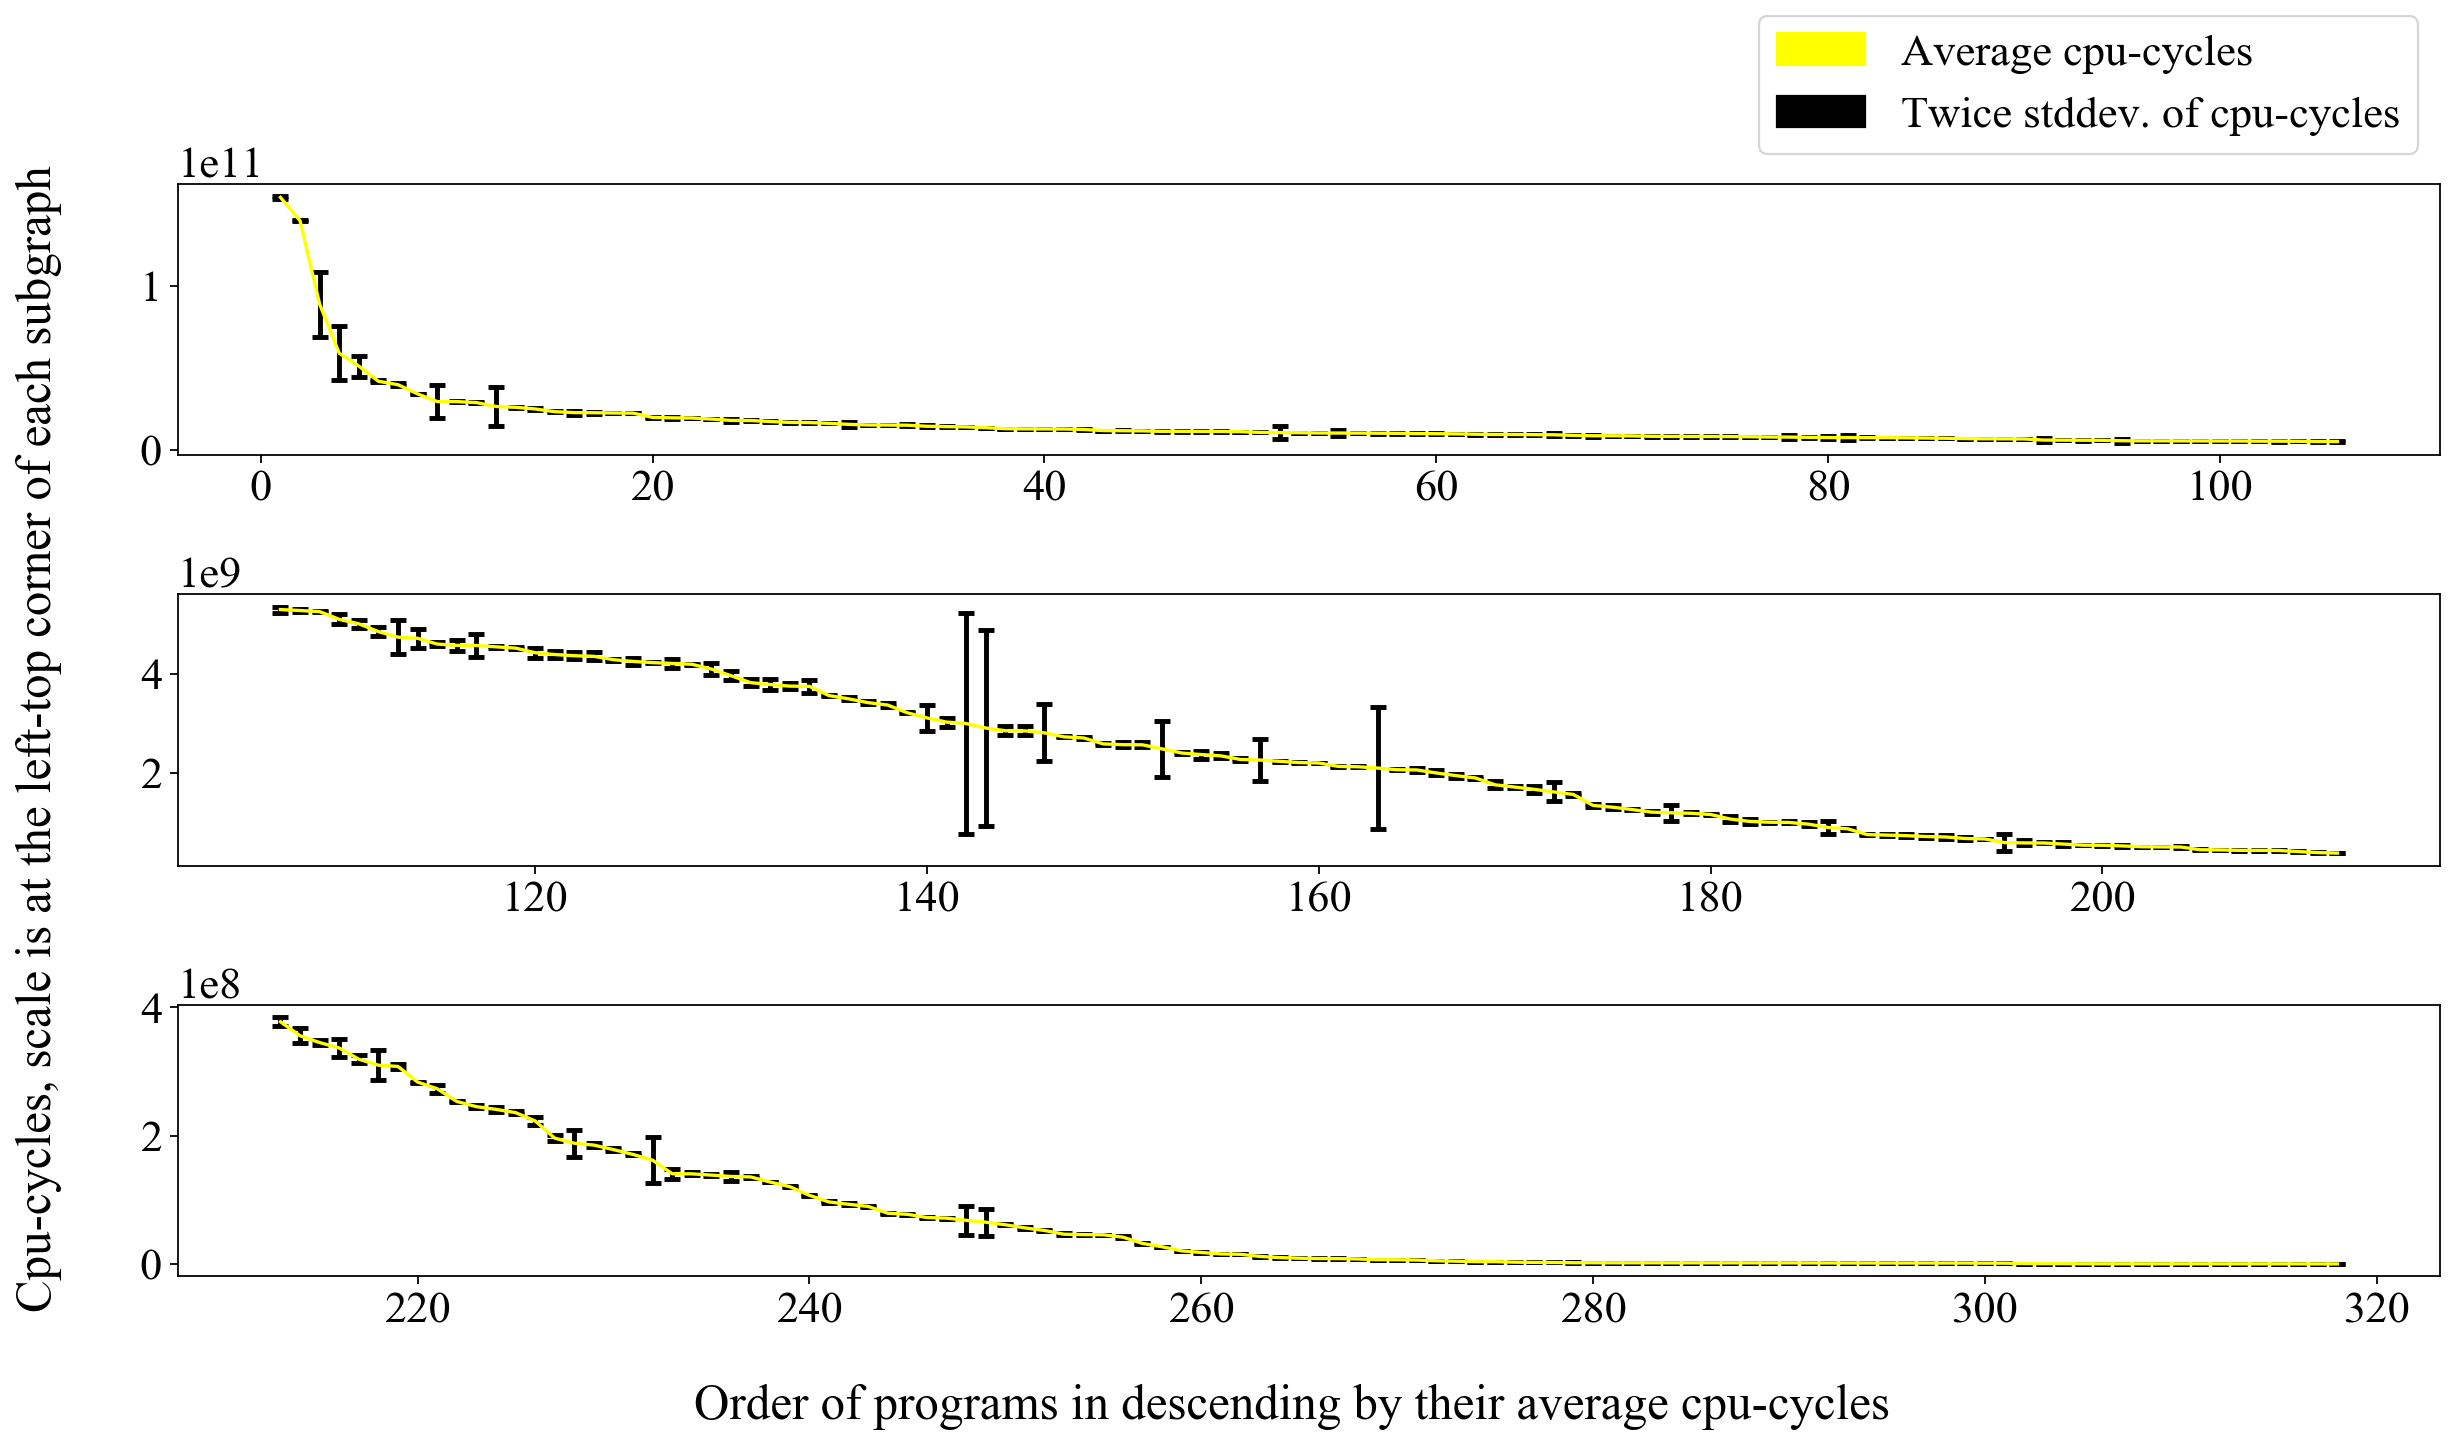

[['CoyoteBench/lpbench', 0.18411363756387616], ['llubenchmark/llu', 0.21950725100907412], ['Polybench/stencils/fdtd-2d/fdtd-2d', 0.29273515626663493], ['Shootout/Shootout-ary3', 0.3413679448483762], ['Shootout-C++/Shootout-C++-ary3', 0.3730437727228065]]


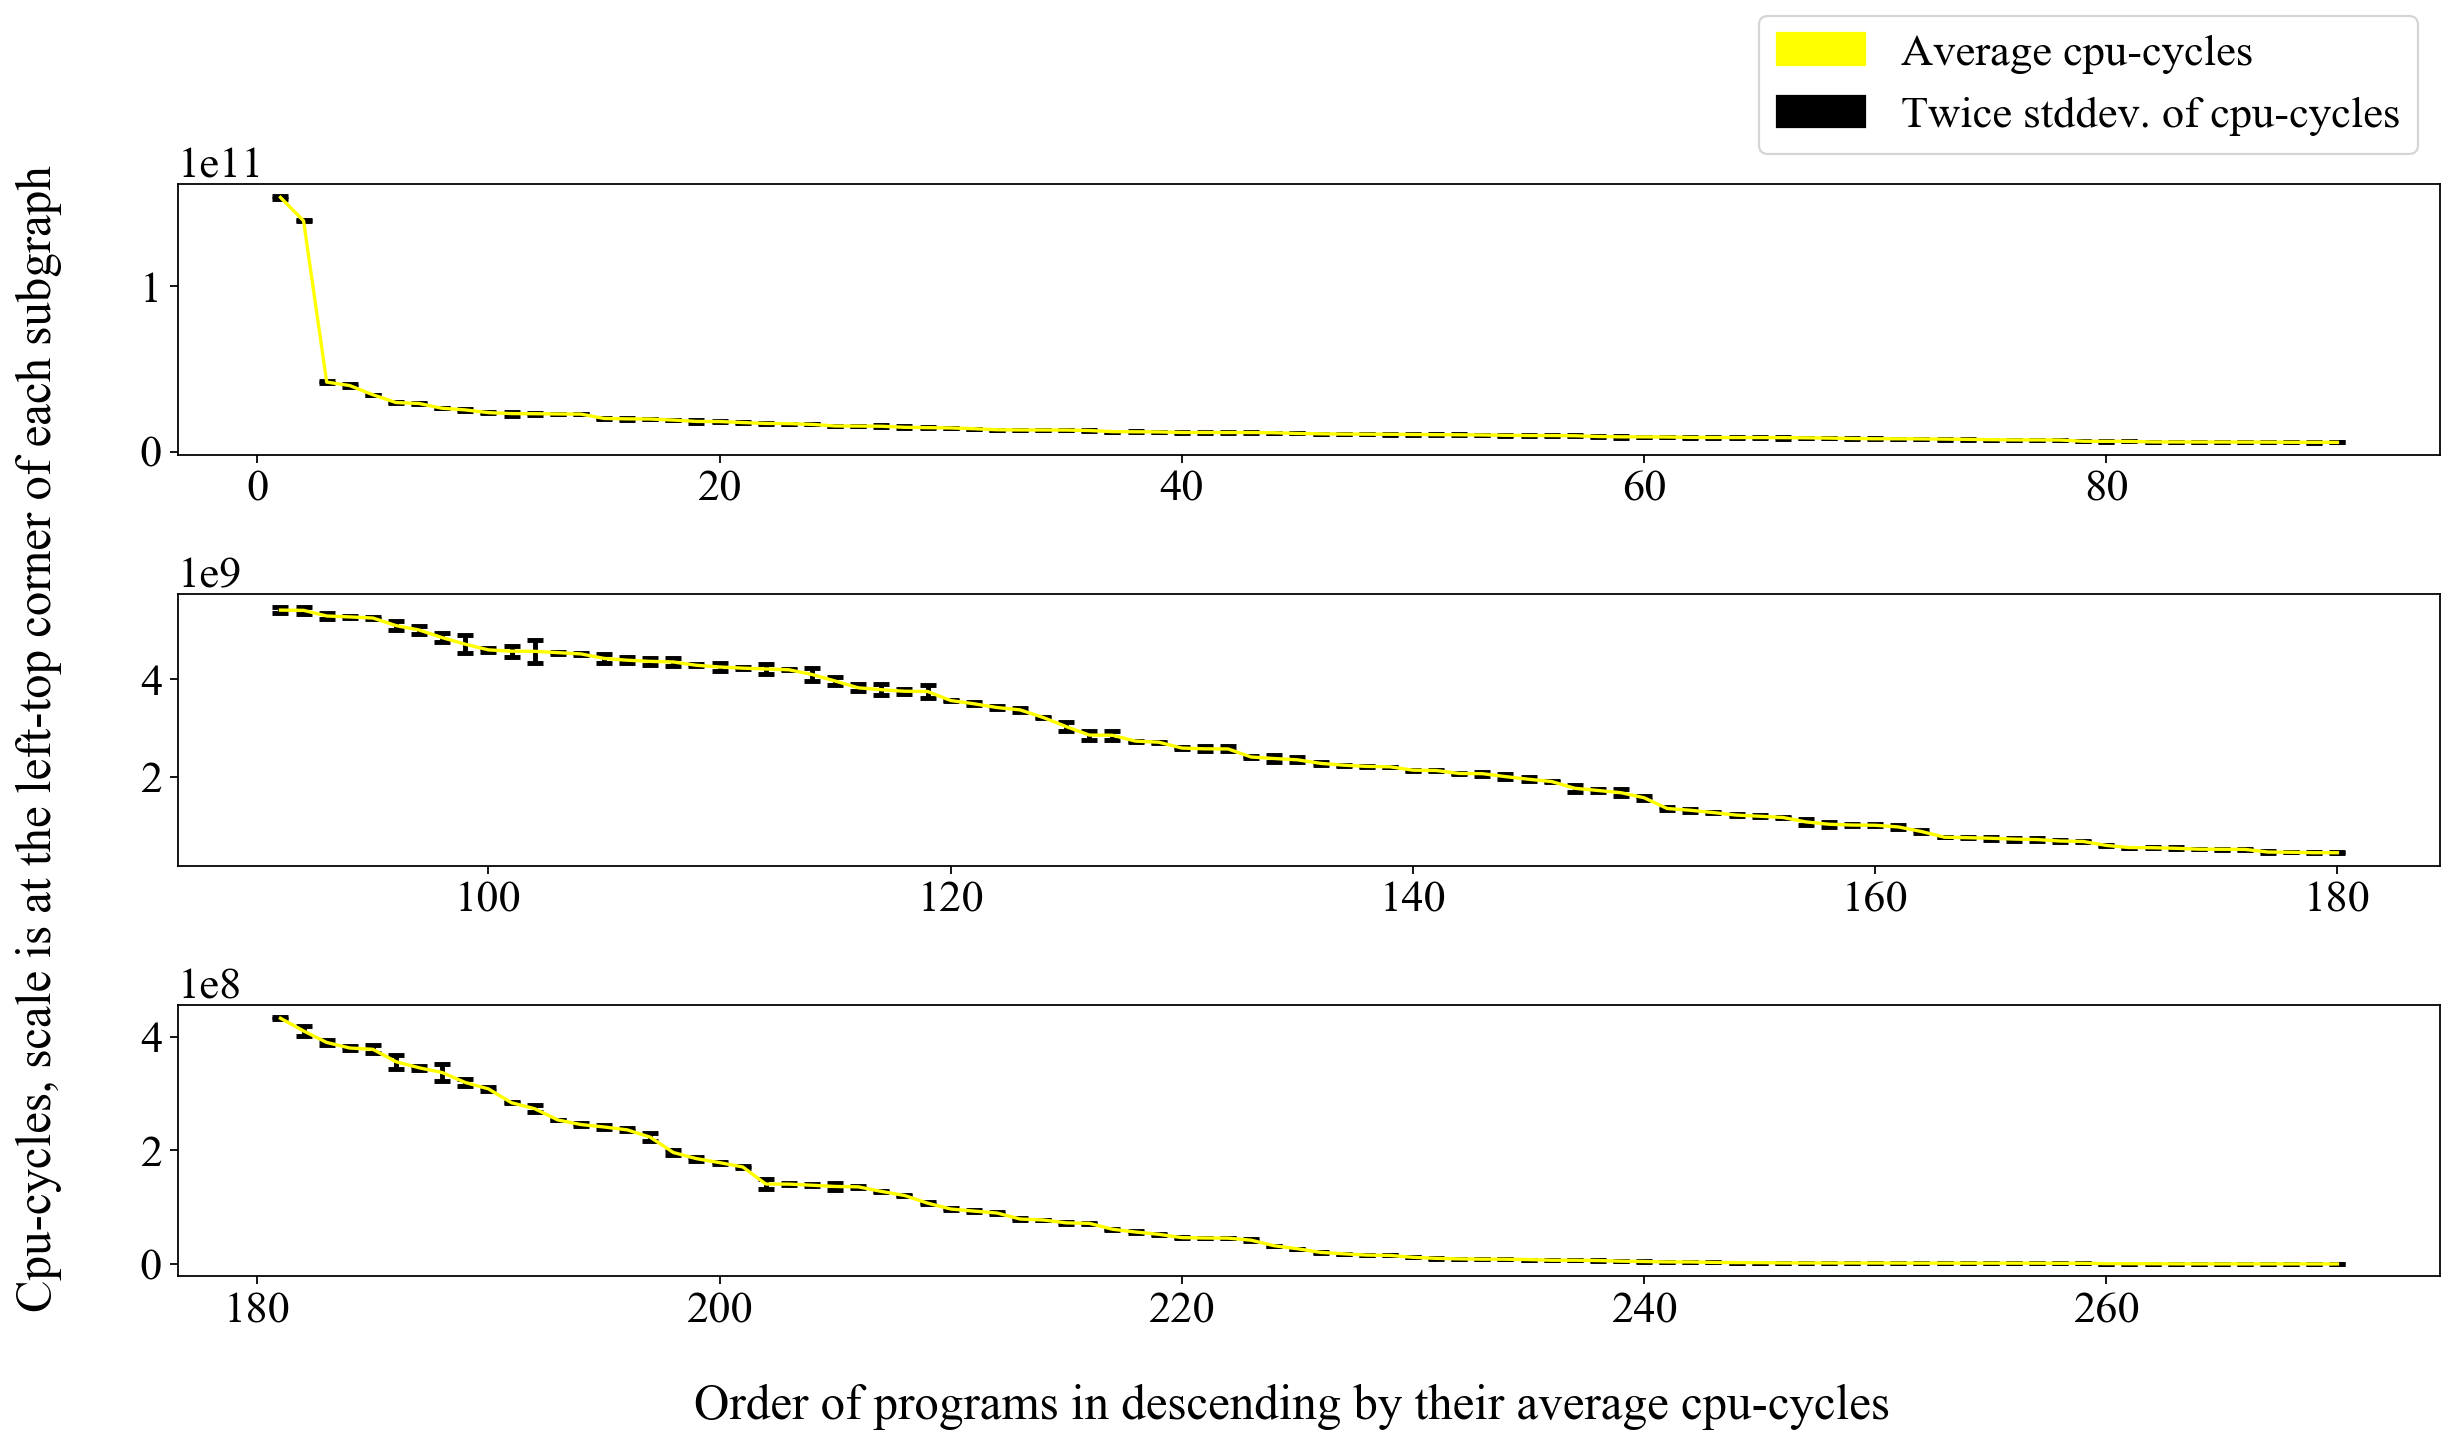

Done.


In [2]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

"""
Warning:
Current code is using the newSTD results,
you should know what do you want.

STD: for "old random" results
newSTD: for "newer training and inference"

Caused by Intel Meltdown.
"""

if __name__ == '__main__':
    '''
    Gather all std files
    '''
    # Get input files
    Input = FileCollector()
    """
    *****Important*****
    # Due to the Intel Meltdown, we re-measure it.
    # We use the new for training and inference
    # The old for writing paper for consistency with the next figure.
    """
    print("For figures, use \"./input/STD\"")
    print("For recorded data for training, use \"./input/newSTD\"")
    print("See the comment above for more details.")
    print('--------------------------------------------------------------')
    StdFiles = Input.collect("./input/STD", "_Features")
    #StdFiles = Input.collect("./input/newSTD", "_Features")
    '''
    Gather all information in files
    '''
    # Get full info about the benchmarks
    benchmarks = BenchmarkDictListsGen()
    stdBenchmarks = benchmarks.genFullInfo(StdFiles)
    '''
    Draw the mean and sigma graph based on full info
    '''
    # Use FullInfo to generate standard deviation
    MeanAndSigmaDict, SortedSigmaList= benchmarks.genCycleStdDeviation(stdBenchmarks)
    # Use arranged data to draw graph
    drawer = GraphDrawer()
    # All Benchmarks From LLVM "test-suite" using perf to get cpu-cycles
    drawer.DrawLineChartWithError("", "PreExperiments_test-suite_all_sigma.png", 
                                  MeanAndSigmaDict, "cpu-cycles-mean", "cpu-cycles-sigma")
    # print last five data the MeanAndSigmaDict with sorted in ascending from sigma
    print(SortedSigmaList[-5:])
    '''
    Strip the full info based on mean and sigma 
    '''
    # Remove the benchmarks that their sigma affects too much
    # In our case, the sigma threshold = 3%. 
    # 15% of the data has to be removed. You can see the result in next code section's result.
    # YOU SHOULD NOT COMMIT THE NEW RemovedStdBenchmarkSigma AFTER RUN THIS SCRIPT AGAIN.
    # Because we did the experiments again after Intel meltdown, the files are correct.
    stripStdBenchmarks = benchmarks.stripSignificantSigmaWithFullInfo(stdBenchmarks, SortedSigmaList, 0.15,
                                                                      "./output/RemovedStdBenchmarkSigma")
    '''
    Draw the mean and sigma graph based on the new full info
    '''
    # Use FullInfo to generate standard deviation
    MeanAndSigmaDict, SortedSigmaList= benchmarks.genCycleStdDeviation(stripStdBenchmarks)
    # Use arranged data to draw graph
    # Stripped Twice Sigma of cpu-cycles From LLVM "test-suite" using perf
    drawer.DrawLineChartWithError("", "PreExperiments_test-suite_stripped_twice_sigma.png", 
                                  MeanAndSigmaDict, "cpu-cycles-mean", "cpu-cycles-sigma")
    '''
    Record the real measurable benchmarks
    '''
    # the order is not fixed, it may be modified for every run of this script.
    # YOU SHOULD NOT COMMIT THE NEW newMeasurableStdBenchmarkMeanAndSigma AFTER RUN THIS SCRIPT AGAIN.
    benchmarks.RecordMeasurableBenchmarks(MeanAndSigmaDict, "./output/newMeasurableStdBenchmarkMeanAndSigma")
    
    
    print("Done.")

Collect 100 files
Collect 100 files
Name=adi, SingleStdDev=0.00040044362952005626, MultiStdDev=0.04246941855756329
Name=atax, SingleStdDev=0.000896047401084802, MultiStdDev=0.043480421381058815
Name=gemver, SingleStdDev=0.0011760296590658974, MultiStdDev=0.06898892179721938
Name=mvt, SingleStdDev=0.001189281402167951, MultiStdDev=0.07083523124149176
Name=Shootout-C++-ary2, SingleStdDev=0.001203644272913441, MultiStdDev=0.15797250632793577
Name=trisolv, SingleStdDev=0.0012564530858247222, MultiStdDev=0.03230973588103267
Name=Shootout-C++-ary, SingleStdDev=0.0012622414627426126, MultiStdDev=0.1670905318507508
Name=cholesky, SingleStdDev=0.0016631050468082326, MultiStdDev=0.05956838882809775
Name=chomp, SingleStdDev=0.001777951629809569, MultiStdDev=0.035968421792885265
Name=jacobi-2d-imper, SingleStdDev=0.0018220628239249944, MultiStdDev=0.14503560692688683
Name=Shootout-C++-nestedloop, SingleStdDev=0.0021960858386122478, MultiStdDev=0.045582917332637155
Name=lowercase, SingleStdDev=0.00

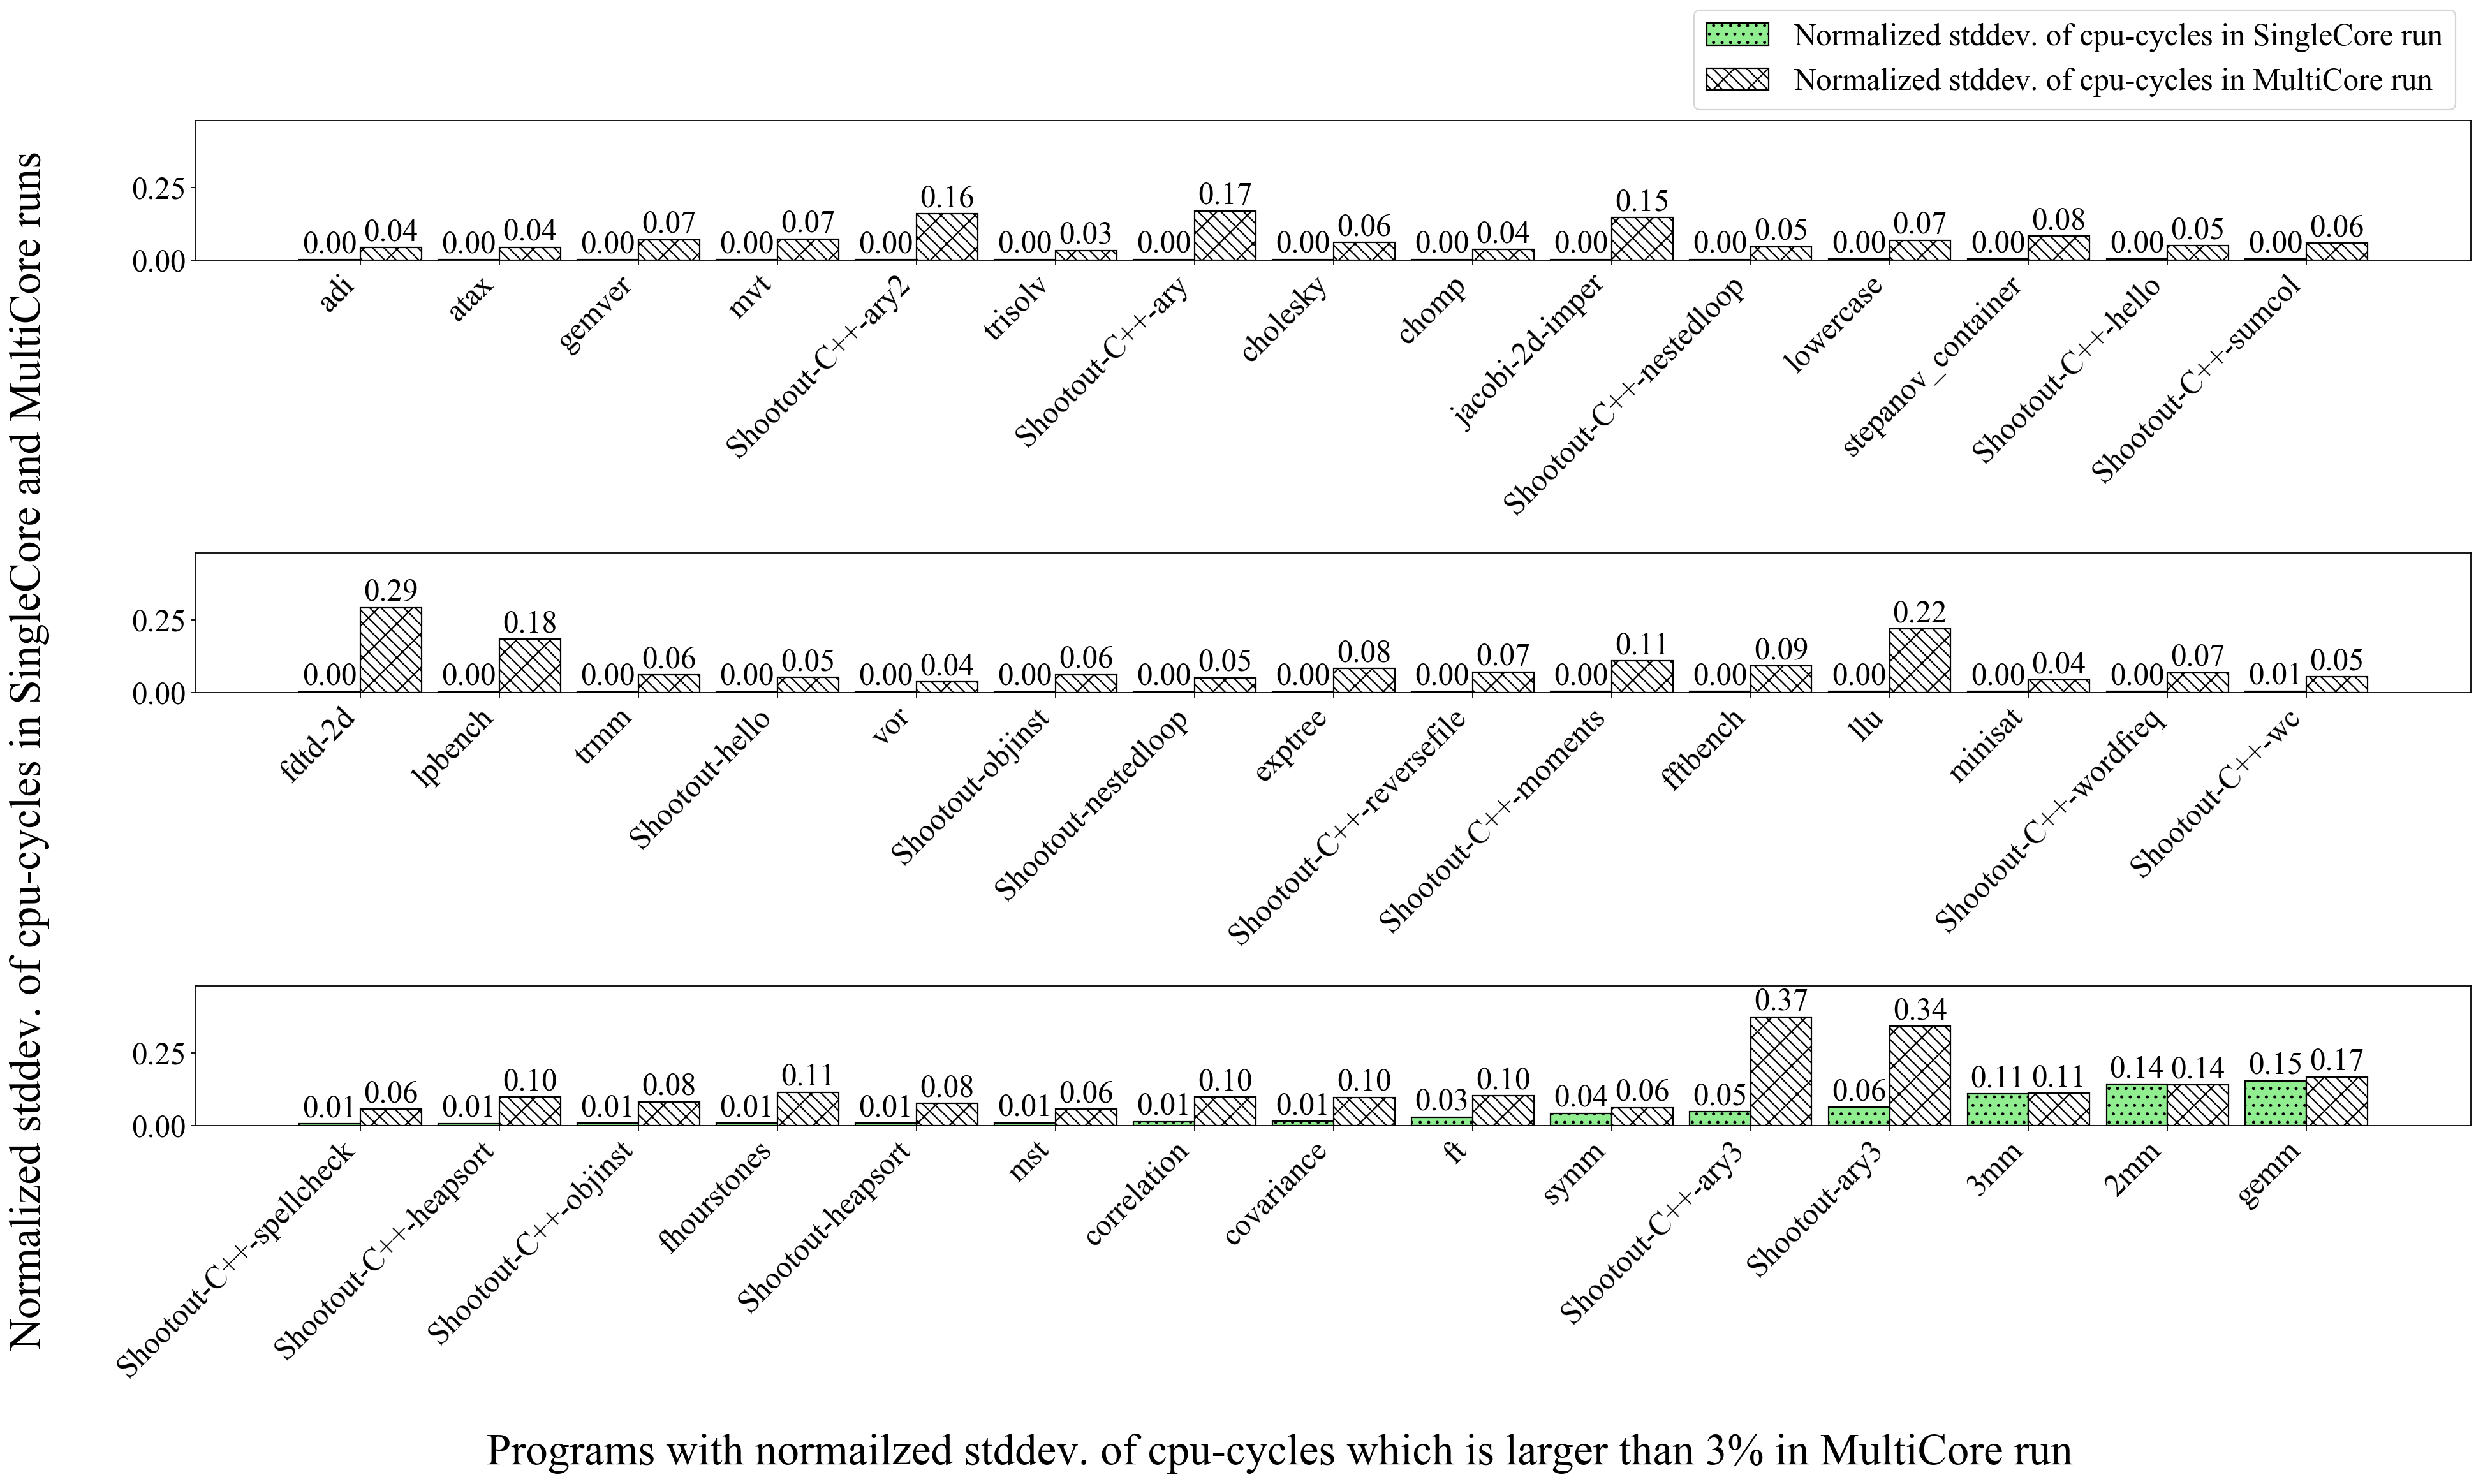

In [3]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

if __name__ == '__main__':
    '''
    Gather all std files
    '''
    # Get input files
    Input = FileCollector()
    StdSingleCoreFiles = Input.collect("./input/SingleCoreSTD", "_Features")
    StdFiles = Input.collect("./input/STD", "_Features")
    '''
    Gather all information in files
    '''
    # Get full info about the benchmarks
    benchmarks = BenchmarkDictListsGen()
    stdSingleCoreBenchmarks = benchmarks.genFullInfo(StdSingleCoreFiles)
    stdBenchmarks = benchmarks.genFullInfo(StdFiles)
    '''
    Draw the sigma graph based on full info
    '''
    # Use FullInfo to generate standard deviation
    SingleCoreMeanAndSigmaDict, SingleCoreSortedSigmaList= benchmarks.genCycleStdDeviation(stdSingleCoreBenchmarks)
    MultiCoreMeanAndSigmaDict, MultiCoreSortedSigmaList= benchmarks.genCycleStdDeviation(stdBenchmarks)
    # Use arranged data to draw graph
    drawer = GraphDrawer()
    # check the "Selected.SingleCore" in LitDriver.py to see why len(SingleCoreSortedSigmaList) 
    # is not as long as len(MultiCoreSortedSigmaList)
    drawer.DrawSigmaComparsion("",
                               "PreExperiments_Normalized-Simga-Comparision-between-SingleCore-and-MultiCore.png", 
                                  SingleCoreSortedSigmaList, MultiCoreSortedSigmaList, Ymax=0.48, Ymin=0.0)
    
    

Collect 108 files
Collect 100 files
Average best passes count is 9

In our case: this need to manually modify to 897.66


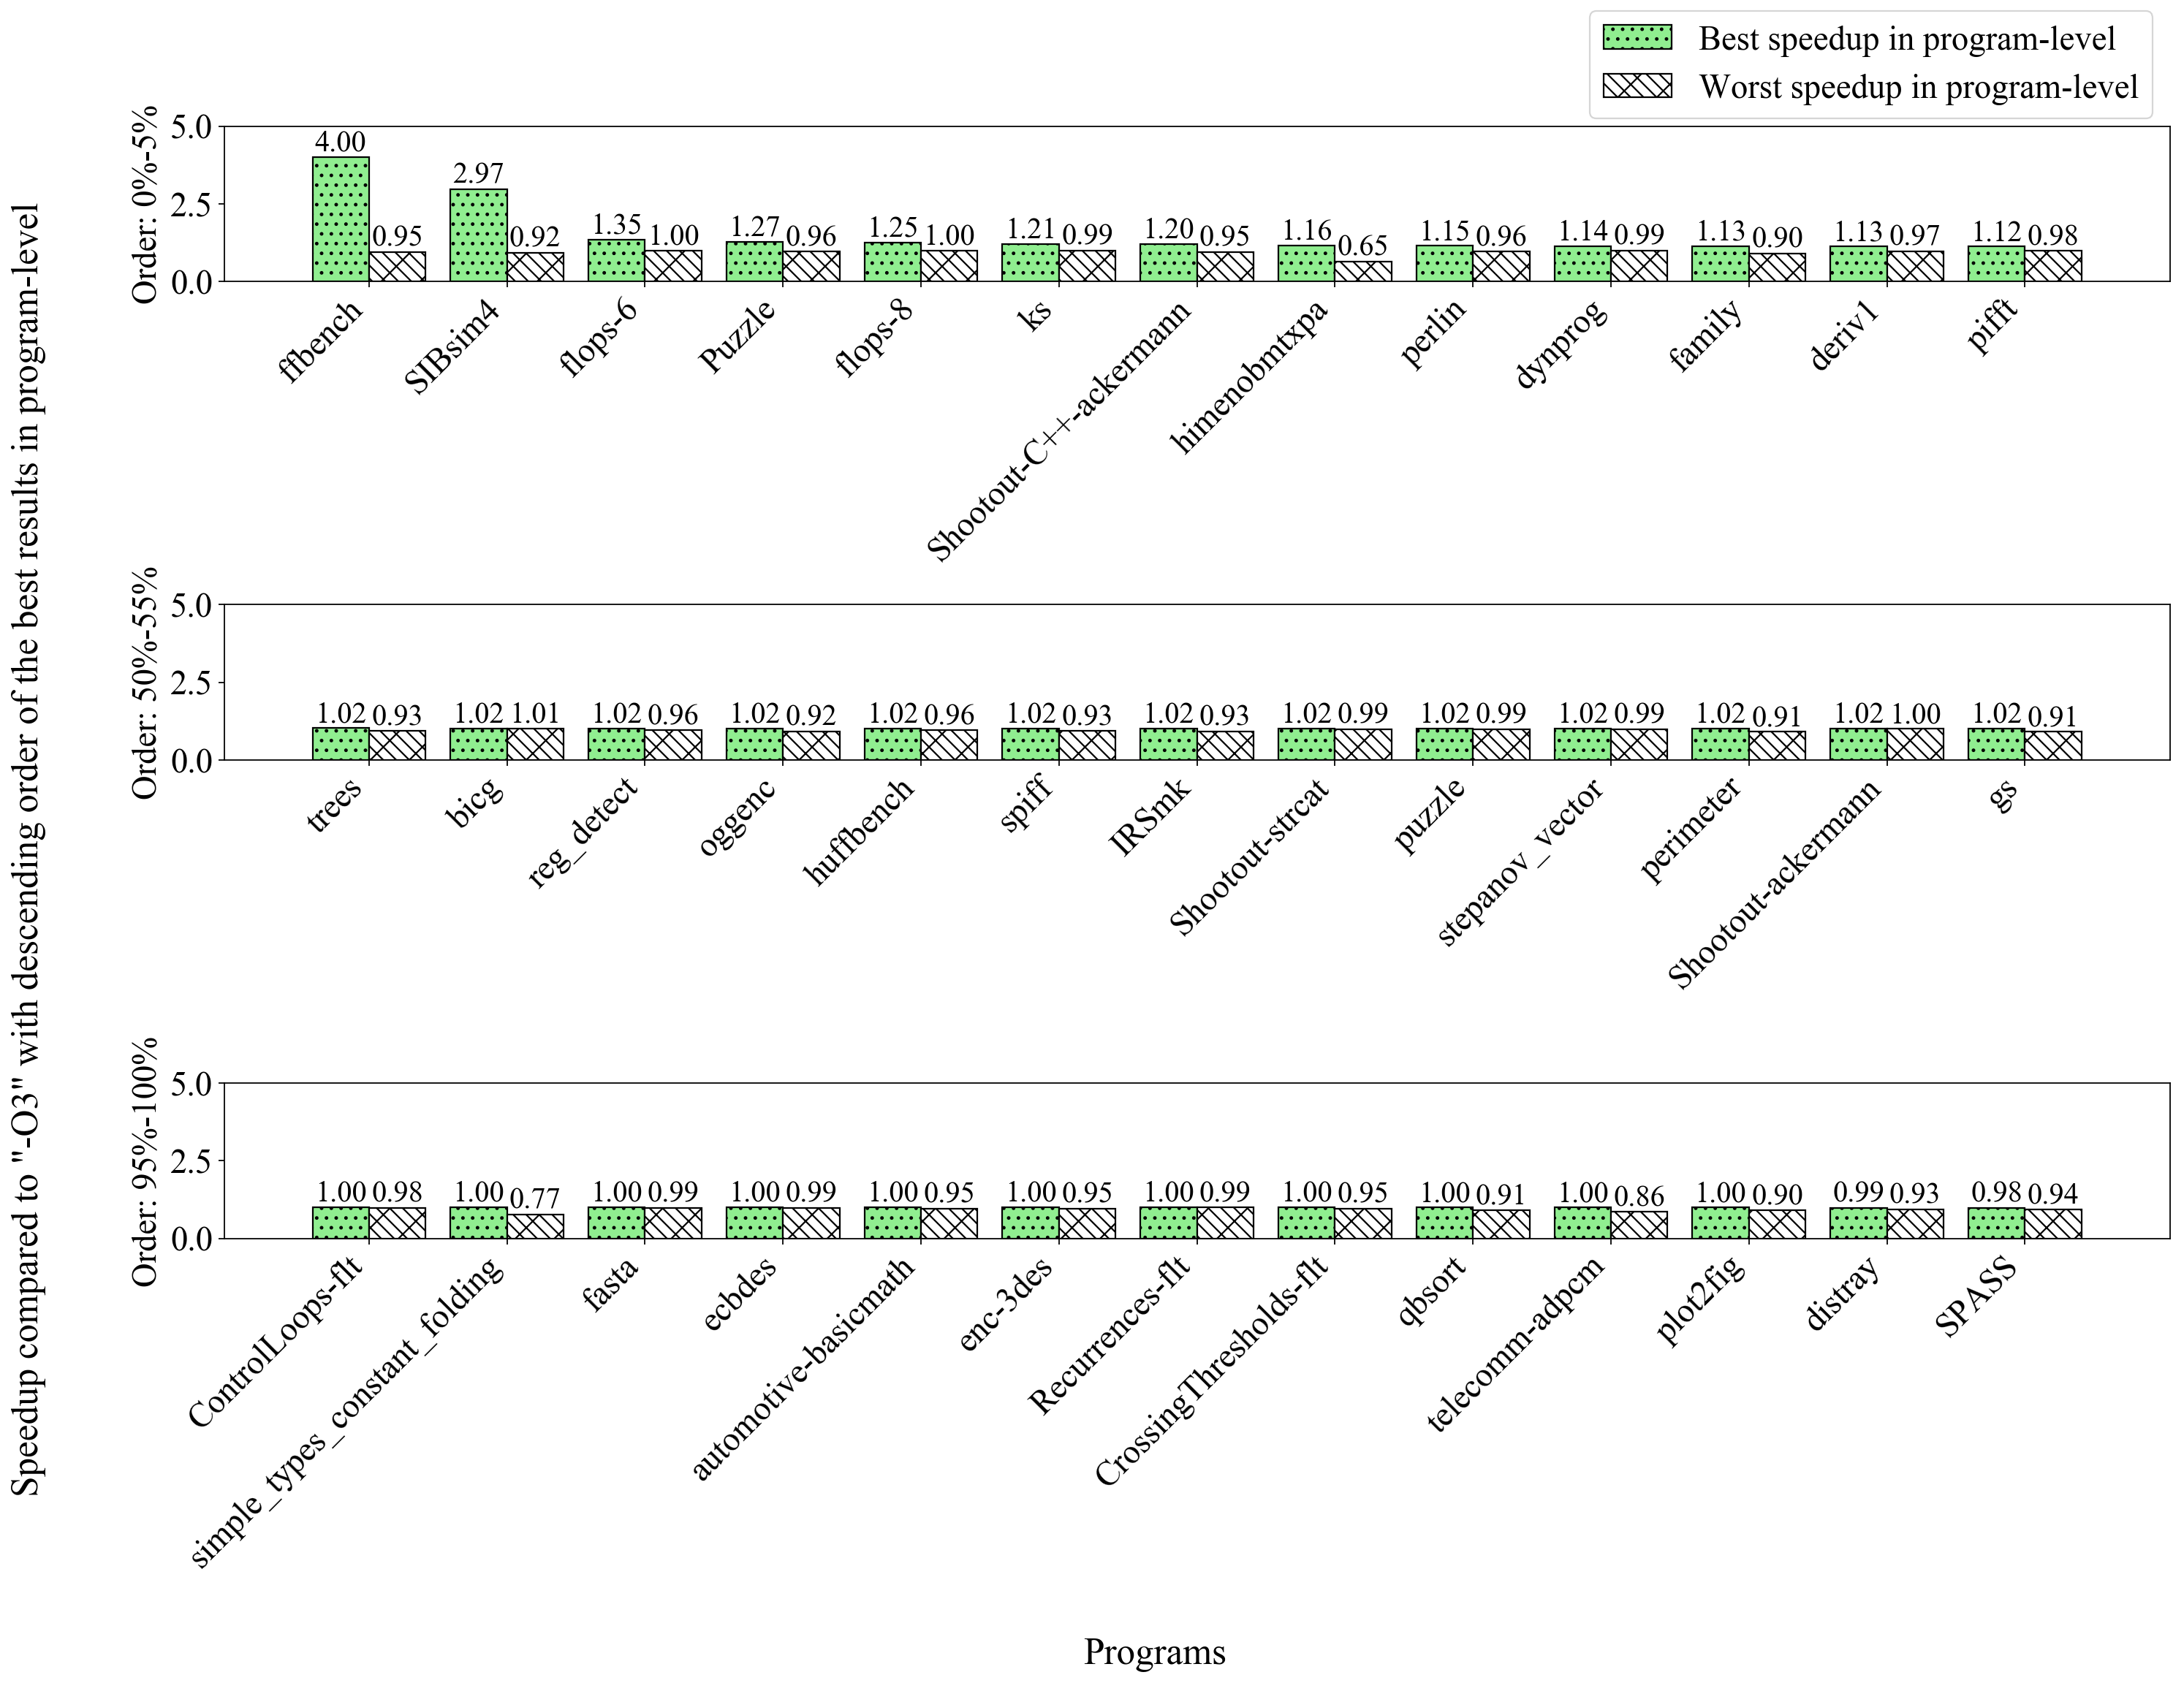

Please modify the value on graph for those > 4 manually
Done.


In [4]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

if __name__ == '__main__':
    '''
    Gather all input files
    '''
    Input = FileCollector()
    RandomBenchmarkLevelFiles = Input.collect("./input/Random-BenchmarkLevel", "_Features")
    StdFiles = Input.collect("./input/STD", "_Features")
    '''
    Gather all information in files
    '''
    benchmarks = BenchmarkDictListsGen()
    RandomBenchmarkLevelBenchmarks = benchmarks.genFullInfo(RandomBenchmarkLevelFiles)
    stdBenchmarks = benchmarks.genFullInfo(StdFiles)
    '''
    Gather the best and worst cpu-cycles and corresponding passes from the FullInfo
    '''
    RandomBestWorstAndPassSetDict = benchmarks.genBestWorstAndPassSetDict(RandomBenchmarkLevelBenchmarks,
                                                                          'cpu-cycles', 'set')
    '''
    Get mean Std cpu-cycles
    '''
    StdMeanAndSigmaDict, _ = benchmarks.genCycleStdDeviation(stdBenchmarks)
    '''
    Gather the normalized best and worst cpu-cycles
    '''
    RandomNormalizedBestWorstAndPassSetDict = benchmarks.genNormalizedBestWorstAndPassSetDict(
        RandomBestWorstAndPassSetDict, StdMeanAndSigmaDict)
    '''
    Get the average best passes count
    '''
    Avg = 0
    Count = 0
    for benchmark, benchmarkInfo in RandomNormalizedBestWorstAndPassSetDict.items():
        Avg += len(benchmarkInfo[2].split())
        Count += 1
    Avg = Avg // Count
    print("Average best passes count is {}\n".format(Avg))
    '''
    For Function-Level as input
    '''
    # Already done as "BenchmarkLevel-BestSpeedupWithPassSet-GraphRecord"
    #benchmarks.WriteBenchmarkWithBestSet("./output/Random-BenchmarkLevelWithBestSet", RandomNormalizedBestWorstAndPassSetDict)
    '''
    Draw the best with worst bar chart
    '''
    drawer = GraphDrawer()
    drawer.DrawRandomBenchmarkLevelSpeedup(RandomNormalizedBestWorstAndPassSetDict, 
                                           "", "PreExperiment_Program-Level_Random_results.png", Ymax=5.0, Ymin = 0.0)

    print("Please modify the value on graph for those > 4 manually")
    print("Done.")
    


Collect 595 files
Collect 108 files
Collect 100 files


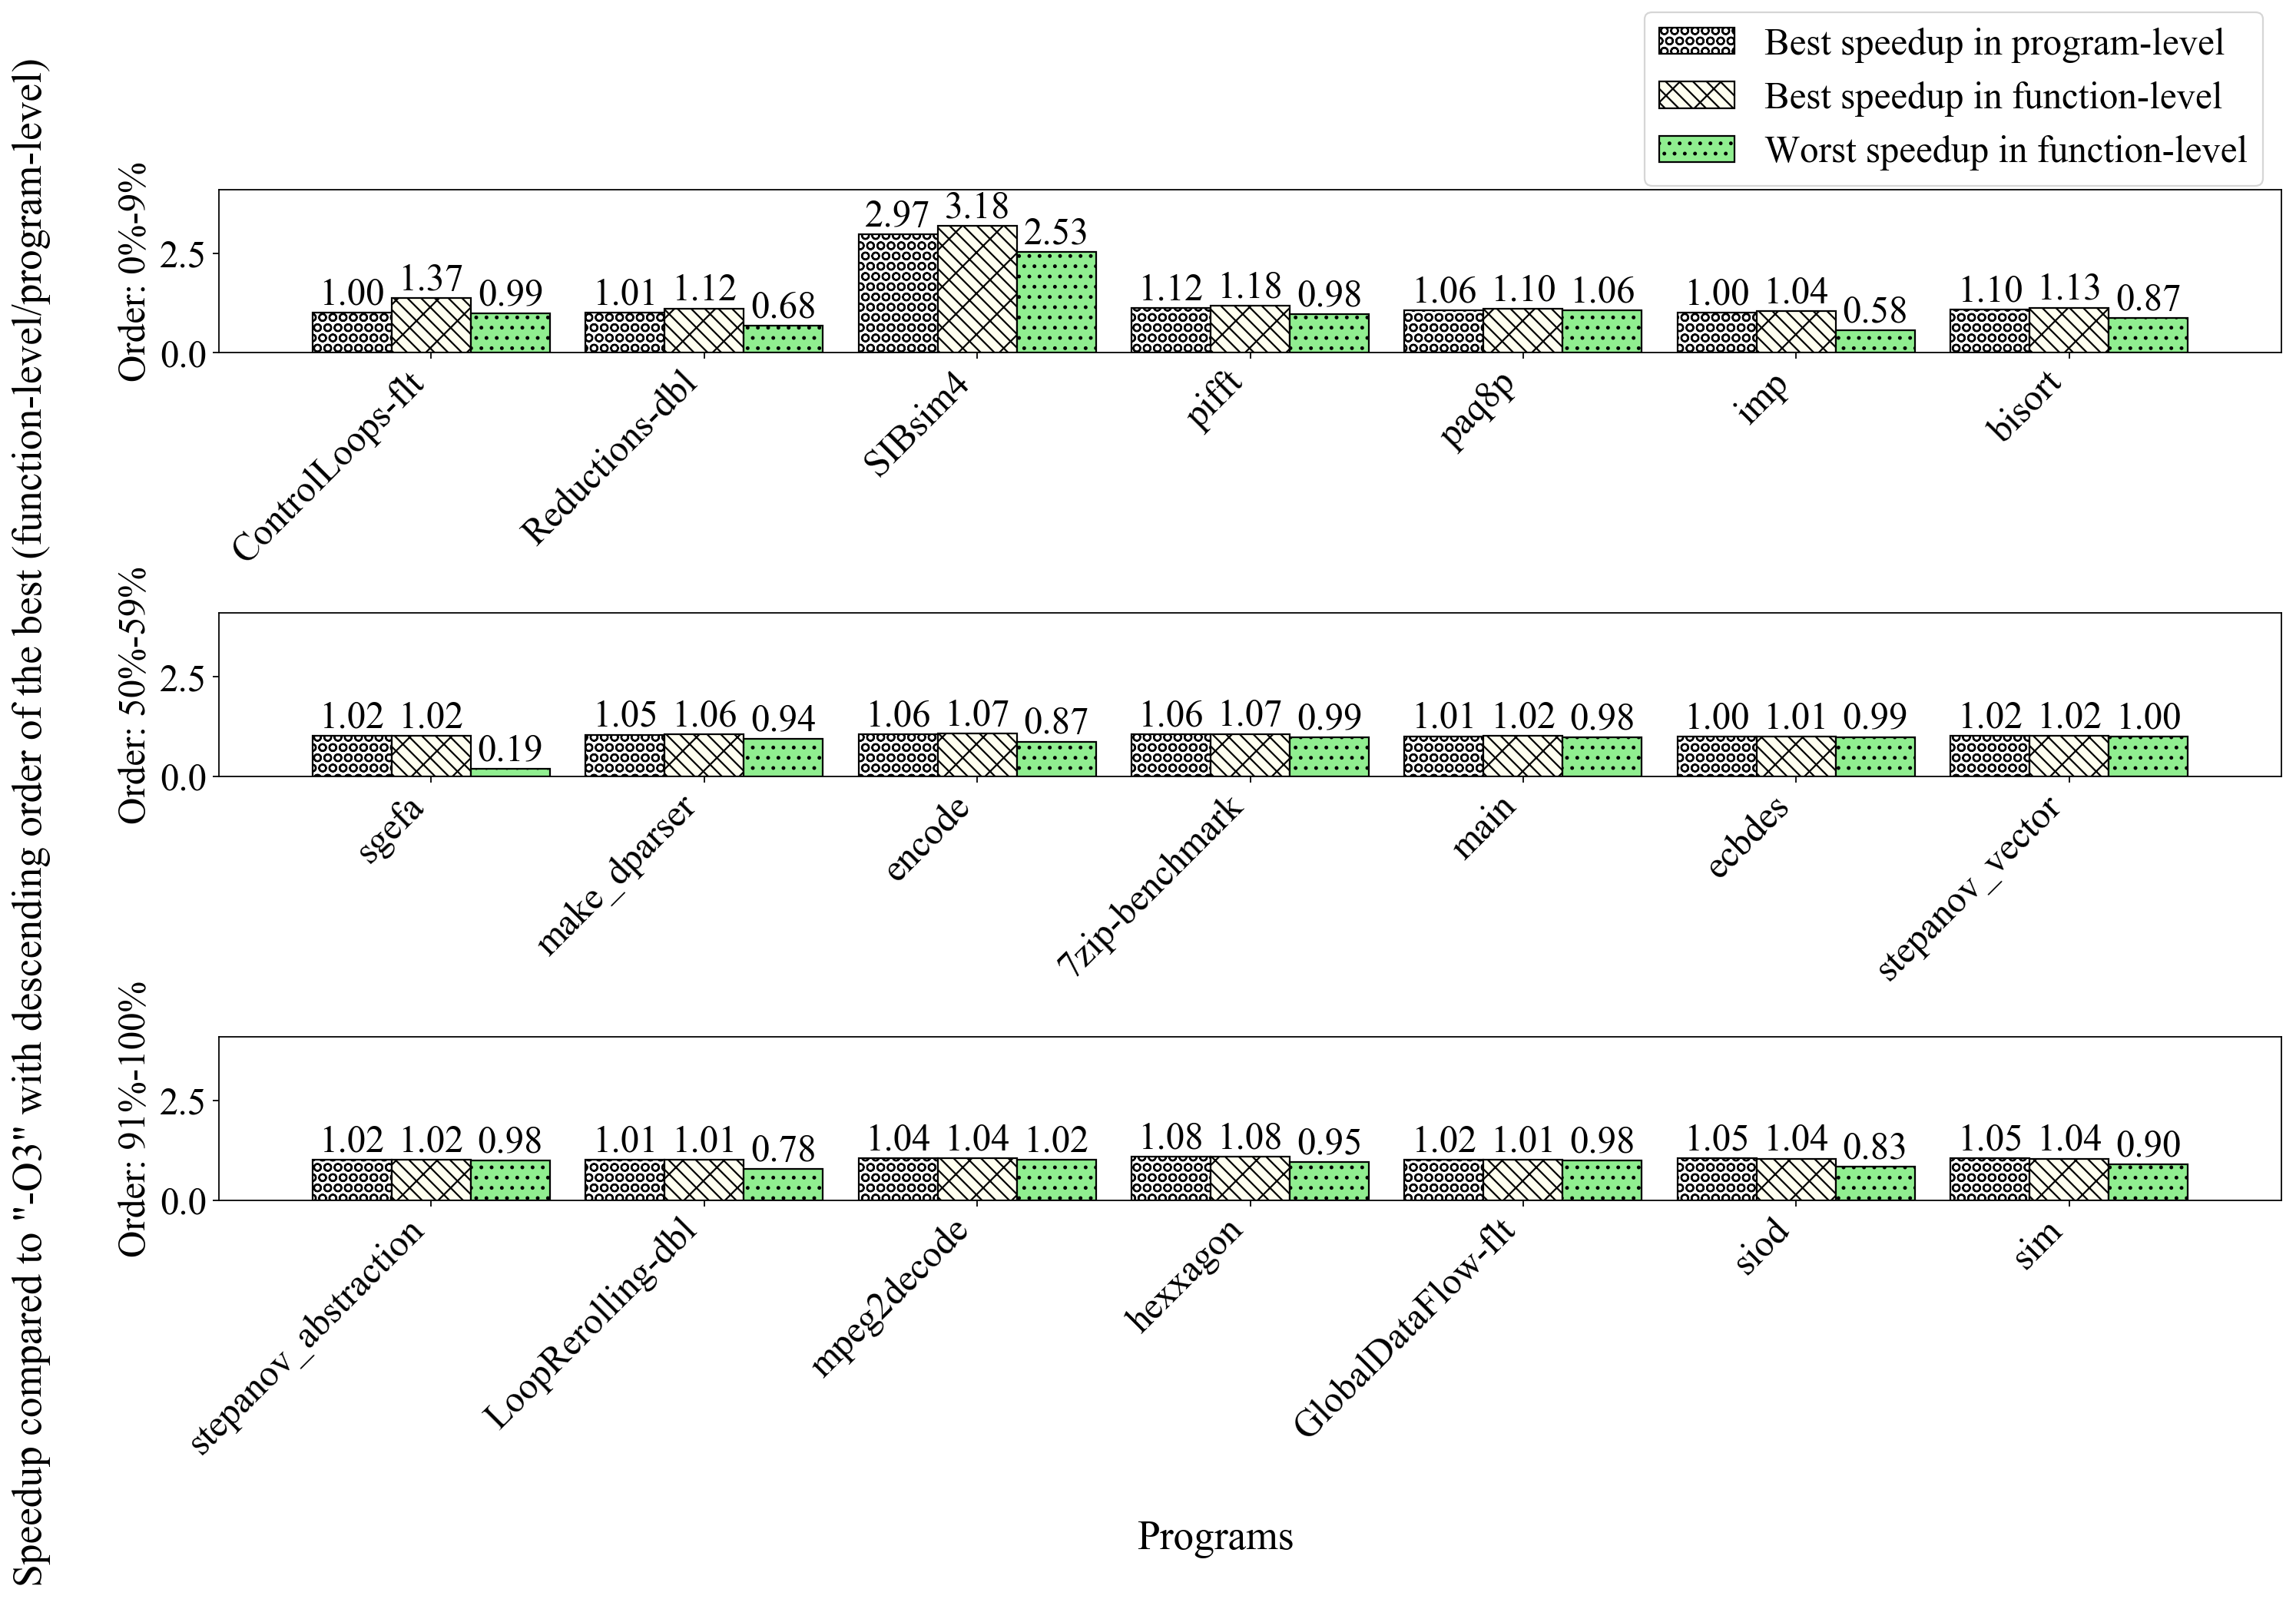

Done.


In [5]:
#!/usr/bin/python3
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statistics
from operator import itemgetter

if __name__ == '__main__':
    '''
    Gather all input files
    '''
    Input = FileCollector()
    RandomFunctionLevelFiles = Input.collect("./input/Random-FunctionLevel", "_Features")
    RandomBenchmarkLevelFiles = Input.collect("./input/Random-BenchmarkLevel", "_Features")
    StdFiles = Input.collect("./input/STD", "_Features")
    '''
    Gather all information in files
    '''
    benchmarks = BenchmarkDictListsGen()
    RandomFunctionLevelBenchmarks = benchmarks.genFullInfo(RandomFunctionLevelFiles)
    RandomBenchmarkLevelBenchmarks = benchmarks.genFullInfo(RandomBenchmarkLevelFiles)
    stdBenchmarks = benchmarks.genFullInfo(StdFiles)
    '''
    Gather the best and worst cpu-cycles and corresponding passes from the FullInfo
    '''
    FunctionLevelBestWorstAndPassSetDict = benchmarks.genBestWorstAndPassSetDict(RandomFunctionLevelBenchmarks,
                                                                          'cpu-cycles', 'set', SetAvability=False)
    BenchmarkLevelBestWorstAndPassSetDict = benchmarks.genBestWorstAndPassSetDict(RandomBenchmarkLevelBenchmarks,
                                                                          'cpu-cycles', 'set')
    '''
    Get mean Std cpu-cycles
    '''
    StdMeanAndSigmaDict, _ = benchmarks.genCycleStdDeviation(stdBenchmarks)
    '''
    Gather the normalized best and worst cpu-cycles
    '''
    NormalizedFunctionLevelBestWorstAndPassSetDict = benchmarks.genNormalizedBestWorstAndPassSetDict(
        FunctionLevelBestWorstAndPassSetDict, StdMeanAndSigmaDict)
    NormalizedBenchmarkLevelBestWorstAndPassSetDict = benchmarks.genNormalizedBestWorstAndPassSetDict(
        BenchmarkLevelBestWorstAndPassSetDict, StdMeanAndSigmaDict)
    '''
    Draw the bar chart
    '''
    drawer = GraphDrawer()
    drawer.DrawFunctionLevelWithBenchmarkLevelCmp(NormalizedBenchmarkLevelBestWorstAndPassSetDict,
                                                  NormalizedFunctionLevelBestWorstAndPassSetDict,
                                                  "",
                                                  "PreExperiment_Function-Level_Random_results.png",
                                                  Ymax=4.1, Ymin = 0.0)

    print("Done.")